<a href="https://colab.research.google.com/github/Amanhacks/DSML/blob/main/LoanTap_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this case study is to develop a predictive model that can determine the likelihood of a borrower defaulting on a loan using data provided by LoanTap (or a similar lending platform). The dataset includes a variety of borrower details such as loan amount, interest rate, term, grade, employment information, annual income, credit history, and other financial and demographic variables.

LoanTap, like many lenders, aims to minimize losses from “charged off” loans (defaults), while maximizing loan approvals to creditworthy applicants. Accurately predicting which applicants are at risk of default is critical for managing risk, setting interest rates, and maintaining the company's financial health.

Specifically, the business goal is to:

Identify borrowers who are likely to default (i.e., have their loan charged off).
Reduce the risk of financial loss by adjusting loan offer decisions or interest rates accordingly.
Balance the trade-off between approving loans and default risk (focusing on reducing false negatives—i.e., not granting loans to those who are likely to default).
The model will be trained to classify loan applicants as “Fully Paid” or “Charged Off” using features from their loan application and credit records. Insights from this model will guide LoanTap's lending strategy and risk management processes.

# Exploration

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder,BinaryEncoder


In [3]:
ordinal_encoder = OrdinalEncoder()
target_encoder = TargetEncoder()
binary_encoder = BinaryEncoder()

In [5]:
#Data overview
df = pd.read_csv('logistic_regression.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# EDA

In [6]:
#Information on every column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111714 entries, 0 to 111713
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             111714 non-null  float64
 1   term                  111714 non-null  object 
 2   int_rate              111714 non-null  float64
 3   installment           111714 non-null  float64
 4   grade                 111714 non-null  object 
 5   sub_grade             111714 non-null  object 
 6   emp_title             105310 non-null  object 
 7   emp_length            106576 non-null  object 
 8   home_ownership        111714 non-null  object 
 9   annual_inc            111713 non-null  float64
 10  verification_status   111713 non-null  object 
 11  issue_d               111713 non-null  object 
 12  loan_status           111713 non-null  object 
 13  purpose               111713 non-null  object 
 14  title                 111216 non-null  object 
 15  

In [7]:
#Shape of the data
print("Shape : ",df.shape)

Shape :  (111714, 27)


In [8]:
#data is unbalanced we might have have to take care of it later
df['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
Fully Paid,0.804141
Charged Off,0.195859


In [9]:
#Doing binary encoding of loan_status
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

<Axes: xlabel='loan_status', ylabel='int_rate'>

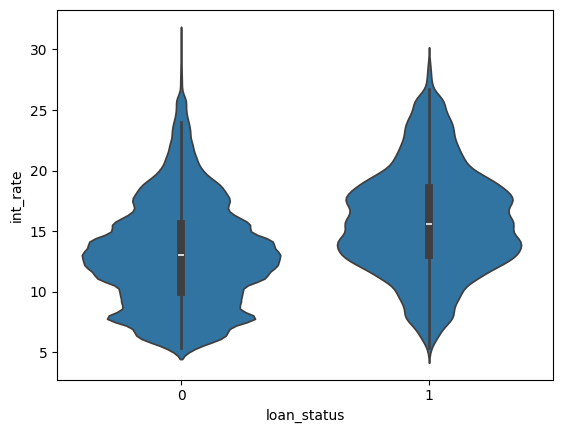

In [10]:
sns.violinplot(x='loan_status',y='int_rate',data=df)

/tmp/ipython-input-11-922117252.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('int_rate_bin')['loan_status'].mean()
/tmp/ipython-input-11-922117252.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('int_rate_bin')['int_rate'].mean()


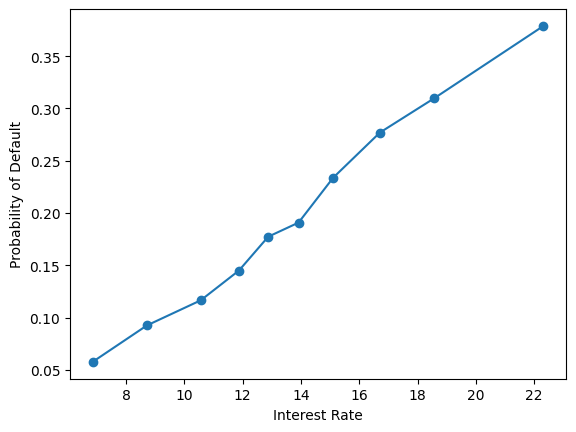

In [11]:
# Calculate the mean default rate in each bin
df['int_rate_bin'] = pd.qcut(df['int_rate'], q=10, duplicates='drop')

bin_means = df.groupby('int_rate_bin')['loan_status'].mean()
bin_centers = df.groupby('int_rate_bin')['int_rate'].mean()
plt.plot(bin_centers, bin_means, 'o-')
plt.xlabel("Interest Rate")
plt.ylabel("Probability of Default")
plt.show()
df.drop('int_rate_bin',axis=1,inplace=True)

<Axes: xlabel='emp_length', ylabel='count'>

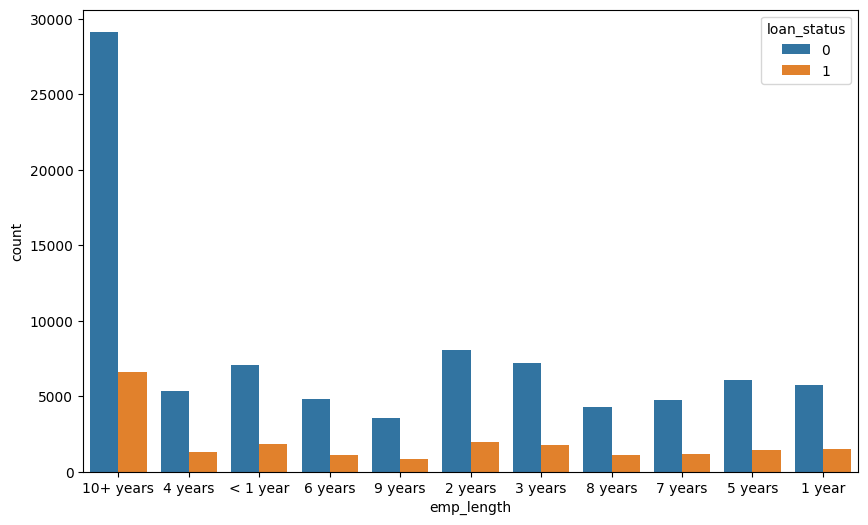

In [12]:
#count of defaulters and non-defaulters according to employment length
df['emp_length'].value_counts()
plt.figure(figsize=(10,6))
sns.countplot(x='emp_length',hue='loan_status',data=df)

In [13]:
#chi2 test to check relation between loan_status and emp_length, comes out to be less then 0.5, So by 95% confidence we can say that they are related
chi2_contingency(pd.crosstab(df['loan_status'],df['emp_length']))

Chi2ContingencyResult(statistic=np.float64(36.9562234327875), pvalue=np.float64(5.758878780916061e-05), dof=10, expected_freq=array([[ 5835.4786162 , 28870.39019104,  8123.45804872,  7202.44937885,
         5351.54511335,  6052.80434619,  4783.58976693,  4760.16059901,
         4358.63313504,  3558.00191413,  7206.48889056],
       [ 1387.5213838 ,  6864.60980896,  1931.54195128,  1712.55062115,
         1272.45488665,  1439.19565381,  1137.41023307,  1131.83940099,
         1036.36686496,   845.99808587,  1713.51110944]]))

In [14]:
# imputation for emp_length by binning data according to annual_inc and then taking mode of every group
income_bins = list(range(0, 200001, 20000))
income_labels = [f"{b}-{b+20000}" for b in income_bins[:-1]] + ["200k+"]

# Assign bins (everything above 200k goes to the last bin)
df['annual_inc_bin'] = pd.cut(df['annual_inc'],
                              bins=income_bins + [float('inf')],
                              labels=income_labels,
                              right=False)

In [15]:
emp_length_mode_by_bin = df.groupby('annual_inc_bin')['emp_length'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

/tmp/ipython-input-15-133974081.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emp_length_mode_by_bin = df.groupby('annual_inc_bin')['emp_length'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)


In [16]:
def fill_emp_length(row):
    if pd.isnull(row['emp_length']):
        bin_val = row['annual_inc_bin']
        # Fallback to most common mode in whole data if no mode for bin
        if pd.isnull(bin_val) or emp_length_mode_by_bin.loc[bin_val] is None:
            return df['emp_length'].mode()[0]
        return emp_length_mode_by_bin.loc[bin_val]
    return row['emp_length']

df['emp_length'] = df.apply(fill_emp_length, axis=1)

Text(0, 0.5, 'Employee Title')

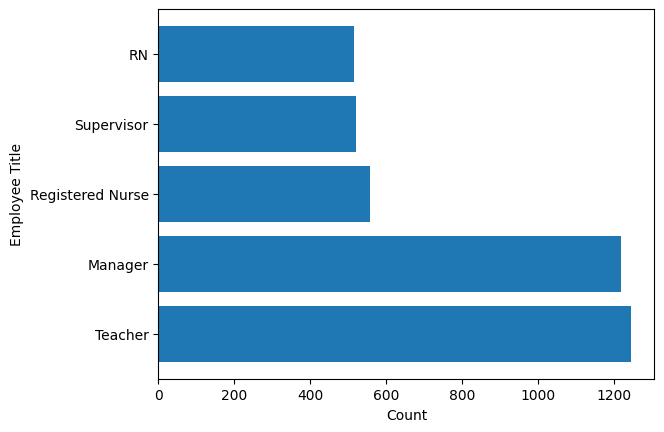

In [17]:
#top 10 jobs who took more loans.

plt.barh(df['emp_title'].value_counts()[:5].index,df['emp_title'].value_counts()[:5].values)
plt.xlabel('Count')
plt.ylabel('Employee Title')


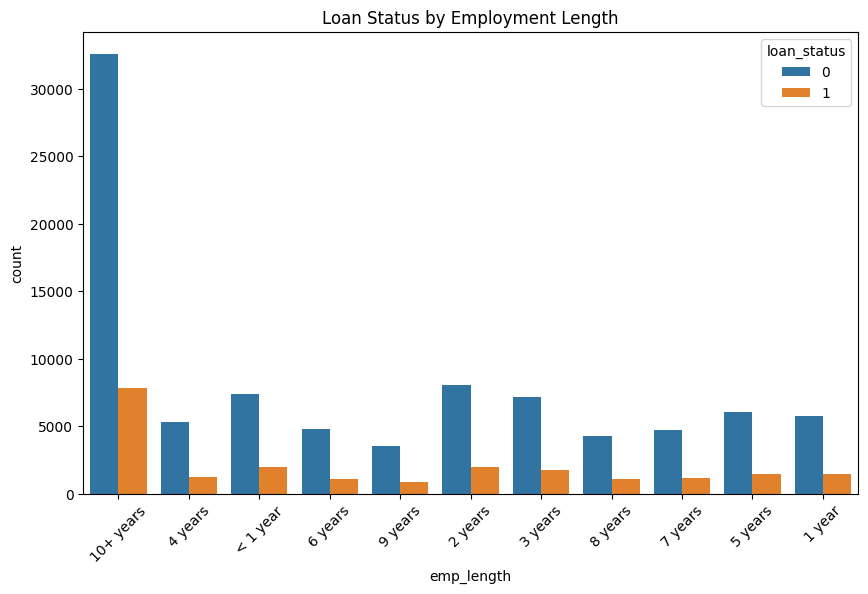

In [18]:
# Lets check if employment length is havinf any relationship with loan_status or not
plt.figure(figsize=(10,6))
sns.countplot(data = df,x='emp_length',hue='loan_status')
plt.xticks(rotation=45)
plt.title("Loan Status by Employment Length")
plt.show()

Text(0.5, 0, 'Employment Length')

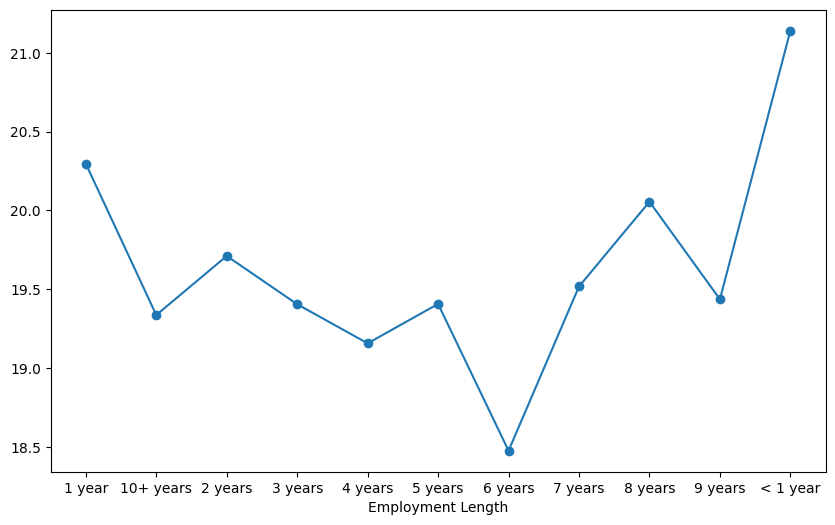

In [19]:
#Defaulter rate with employment length
plt.figure(figsize=(10,6))
defaulter_percentage = df.groupby('emp_length')['loan_status'].mean()*100
plt.plot(defaulter_percentage.index,defaulter_percentage.values,'o-')
plt.xlabel('Employment Length')

In [20]:
#chi2 test to check relation between two categorical variable
chi2_contingency(pd.crosstab(df['loan_status'],df['emp_length']))


Chi2ContingencyResult(statistic=np.float64(24.992084710581967), pvalue=np.float64(0.005360528916463692), dof=10, expected_freq=array([[ 5808.25822189, 32478.15884312,  8085.56505899,  7168.852561  ,
         5326.58209356,  6024.57020606,  4761.27605314,  4737.9561738 ,
         4338.30169003,  3541.4051238 ,  7562.07397461],
       [ 1414.74177811,  7910.84115688,  1969.43494101,  1746.147439  ,
         1297.41790644,  1467.42979394,  1159.72394686,  1154.0438262 ,
         1056.69830997,   862.5948762 ,  1841.92602539]]))

In [21]:
df.isnull().sum()
## we can see that around 18000 null values are present lets check how can we fix it.


,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,6404
emp_length,0
home_ownership,0
annual_inc,1


Text(0, 0.5, 'Employee Title')

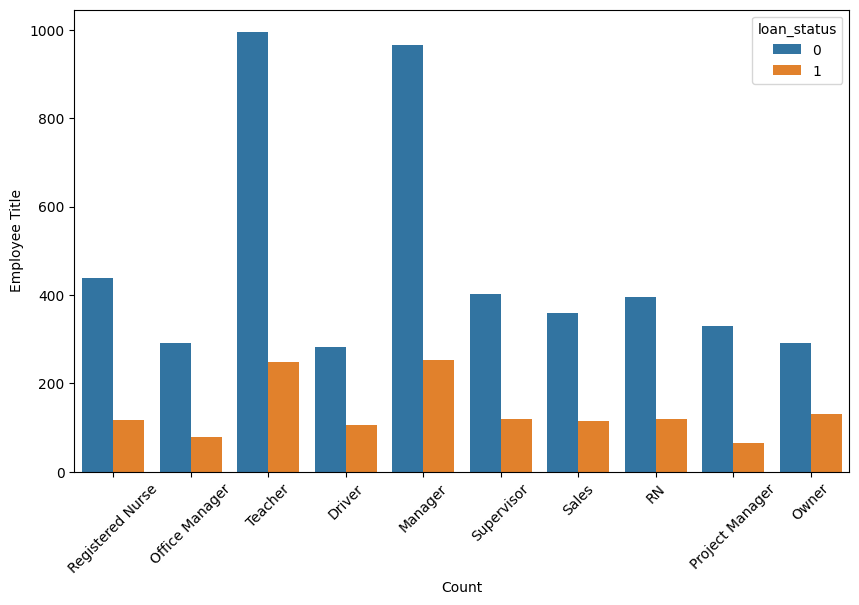

In [22]:
#Fig to show defaulter ratio in top 10 loan seaker emp_title
plt.figure(figsize=(10,6))

top_10_jobs = df['emp_title'].value_counts()[:10]
df_top_10 = df[df['emp_title'].isin(top_10_jobs.index)]
sns.countplot(x='emp_title',data=df_top_10,hue='loan_status')
plt.xticks(rotation=45)
plt.xlabel('Count')
plt.ylabel('Employee Title')

In [23]:
#emp_title distribution
encoded = df.groupby('emp_title')['loan_status'].mean()
print(encoded.describe())

count    58549.000000
mean         0.183737
std          0.370131
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


In [24]:
#not very distubuted so we can drop it
df.drop('emp_title',axis=1, inplace=True)

In [25]:
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0
annual_inc,1
verification_status,1


In [26]:
#Imputing mort_account based on total account for a loan seaker
from math import nan
total_acc_avg = df.groupby('total_acc')['mort_acc'].mean()
mort_acc_median = df['mort_acc'].median()

def fill_mort_acc(row):
    if pd.isnull(row['mort_acc']):
        if pd.isnull(row['total_acc']):
            return mort_acc_median
        group_mean = total_acc_avg.get(row['total_acc'], mort_acc_median) # Use .get() with a default value
        if pd.isnull(group_mean): # Check if the calculated group_mean is NaN
            return mort_acc_median
        return group_mean
    return row['mort_acc']

df['mort_acc'] = df.apply(fill_mort_acc, axis=1)

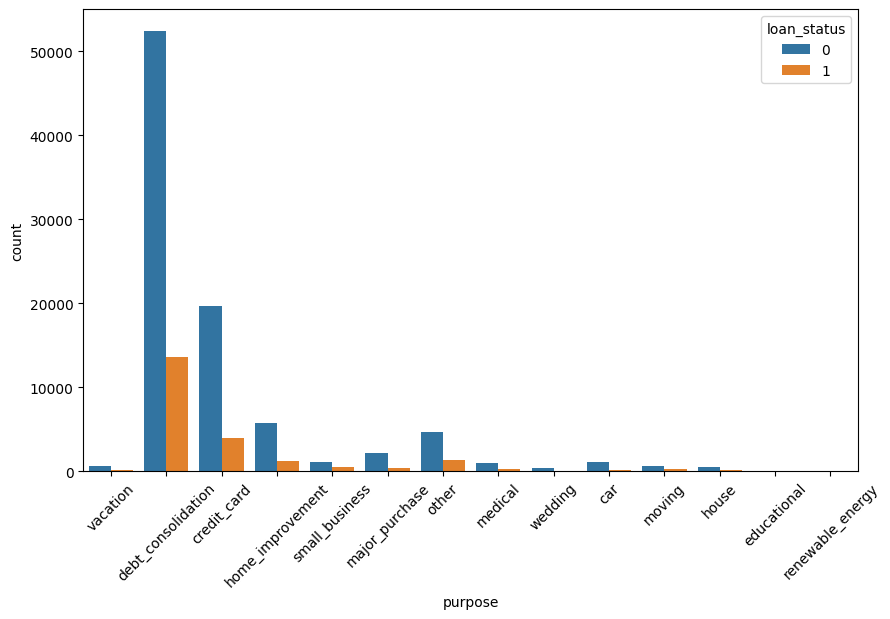

In [27]:
#defaulty ratio for every purpose
plt.figure(figsize=(10,6))
sns.countplot(x='purpose',hue='loan_status',data=df)
plt.xticks(rotation=45)
plt.show()

In [28]:
#Chi square test to check relation between loan status and purpose , p_value is less then 0.05 so they are related
chi2_contingency(pd.crosstab(df['loan_status'],df['purpose']))

Chi2ContingencyResult(statistic=np.float64(390.92891459084143), pvalue=np.float64(1.8401286500681098e-75), dof=13, expected_freq=array([[1.05583709e+03, 1.89447571e+04, 5.30523962e+04, 5.54857268e+01,
        5.52846916e+03, 4.98567400e+02, 2.02884766e+03, 9.57731893e+02,
        6.64220440e+02, 4.77820563e+03, 6.91561233e+01, 1.24963506e+03,
        5.58073832e+02, 3.91616652e+02],
       [2.57162909e+02, 4.61424293e+03, 1.29216038e+04, 1.35142732e+01,
        1.34653084e+03, 1.21432600e+02, 4.94152337e+02, 2.33268107e+02,
        1.61779560e+02, 1.16379437e+03, 1.68438767e+01, 3.04364935e+02,
        1.35926168e+02, 9.53833484e+01]]))

In [29]:
#Taking ZIP from address and droping un necessary information
df['zip'] = df['address'].str[-5:]
df['zip'].dropna(inplace=True)
df.drop('address',axis=1,inplace=True)


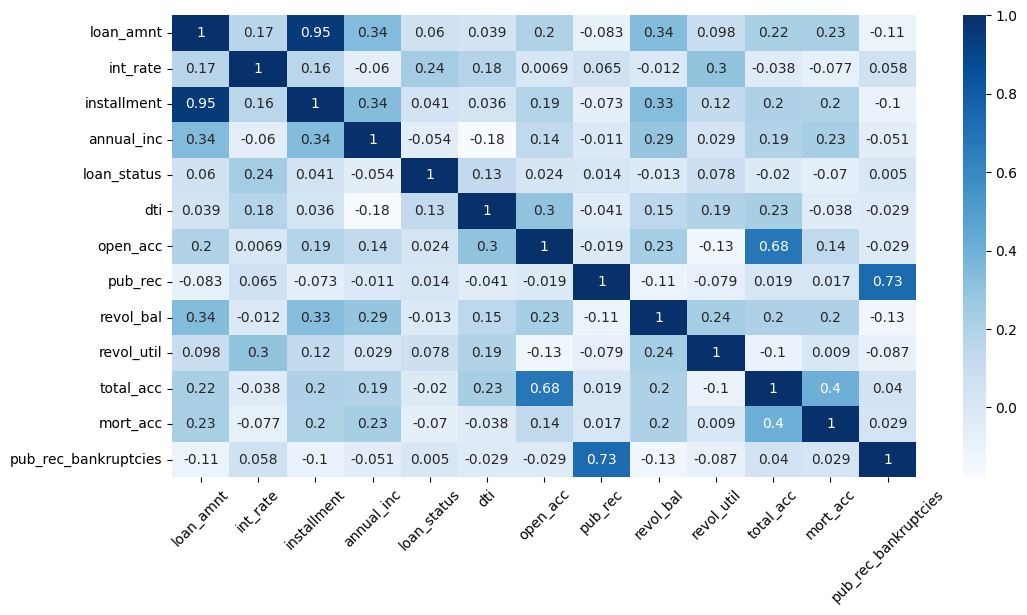

In [30]:
#Heatmap to check the colinearity between every numerical data.
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12,6))
sns.heatmap(df[numerical_cols].corr(),annot=True, cmap = "Blues")
plt.xticks(rotation = 45)
plt.show()

In [31]:
df['pub_rec'].value_counts(dropna=False)
# only one column is null , so we can fill it with mode value
df[df['pub_rec'] == nan]['pub_rec'] = df['pub_rec'].mode()[0]

In [32]:
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0
annual_inc,1
verification_status,1


In [33]:
df.dropna(inplace=True)

In [34]:
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0


# Feature Engineering

In [35]:
# As public is not having direct relation with loan_status we can convert it into a flag to say if anyone had atleast one public records as 1 else 0
df['pub_rec'] = df['pub_rec'].apply(lambda x: 1 if x > 0 else 0)




In [36]:
#same we can do with Mort_acc as we already have total_acc to give us the exact information
df['mort_acc'] = df['mort_acc'].apply(lambda x: 1 if x > 0 else 0)

In [37]:
#Same we can do with Public record of Bankruptcies as one bankrupcy record is enough to decide if the person should be given loan or not.
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)

In [38]:
#dealing with outliers



for col in df.select_dtypes(include='number').columns:
  col_mean = df[col].mean()
  col_std = df[col].std()
  upper_limit = col_mean+3*col_std
  lower_limit = col_mean-3*col_std

  df = df[(df[col]<upper_limit) & (df[col]>lower_limit)]





In [39]:
#train test split of the data
x_train_val,x_test,y_train_val,y_test = train_test_split(df.drop('loan_status',axis=1),df['loan_status'],test_size=0.2,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=0.25,random_state=42)

# Encoding

In [40]:
# as we have only two values in term we can use binary encoding
map_term = lambda x: 0 if x == ' 36 months' else 1

x_train['term'] = x_train['term'].apply(map_term)
x_test['term']  = x_test['term'].apply(map_term)
x_val['term']  = x_val['term'].apply(map_term)

as we need to preserve ordinal relationship we can go for ordinalEncoding

In [41]:

x_train['grade'] = ordinal_encoder.fit_transform(x_train[['grade']])
x_test['grade'] = ordinal_encoder.transform(x_test[['grade']])
x_val['grade'] = ordinal_encoder.transform(x_val[['grade']])

In [42]:
x_train['sub_grade'] = ordinal_encoder.fit_transform(x_train[['sub_grade']])
x_test['sub_grade'] = ordinal_encoder.transform(x_test[['sub_grade']])
x_val['sub_grade'] = ordinal_encoder.transform(x_val[['sub_grade']])

In [43]:
# In this as we don't have any ordinal relationship we can use target encoding

target_encoder.fit(x_train['home_ownership'],y_train)
x_train['home_ownership'] = target_encoder.transform(x_train['home_ownership'])
x_val['home_ownership'] = target_encoder.transform(x_val['home_ownership'])
x_test['home_ownership'] = target_encoder.transform(x_test['home_ownership'])


In [44]:
for col in x_train.select_dtypes(include='object').columns:
  print(col)

emp_length
verification_status
issue_d
purpose
title
earliest_cr_line
initial_list_status
application_type
zip


In [45]:

target_encoder.fit(x_train['verification_status'],y_train)
x_train['verification_status'] = target_encoder.transform(x_train['verification_status'])
x_val['verification_status'] = target_encoder.transform(x_val['verification_status'])
x_test['verification_status'] = target_encoder.transform(x_test['verification_status'])

In [46]:
target_encoder.fit(x_train['issue_d'],y_train)
x_train['issue_d'] = target_encoder.transform(x_train['issue_d'])
x_val['issue_d'] = target_encoder.transform(x_val['issue_d'])
x_test['issue_d'] = target_encoder.transform(x_test['issue_d'])

In [47]:

target_encoder.fit(x_train['purpose'],y_train)
x_train['purpose'] = target_encoder.transform(x_train['purpose'])
x_val['purpose'] = target_encoder.transform(x_val['purpose'])
x_test['purpose'] = target_encoder.transform(x_test['purpose'])

In [48]:
for col in x_train.select_dtypes(include='object').columns:
  print(col)

emp_length
title
earliest_cr_line
initial_list_status
application_type
zip


In [49]:
target_encoder.fit(x_train['earliest_cr_line'],y_train)
x_train['earliest_cr_line'] = target_encoder.transform(x_train['earliest_cr_line'])
x_val['earliest_cr_line'] = target_encoder.transform(x_val['earliest_cr_line'])
x_test['earliest_cr_line'] = target_encoder.transform(x_test['earliest_cr_line'])

In [50]:
col = 'initial_list_status'

# Fit the encoder on the training column (as DataFrame)
binary_encoder.fit(x_train[[col]])

# Transform and get encoded DataFrames for each split
x_train_bin = binary_encoder.transform(x_train[[col]])
x_val_bin   = binary_encoder.transform(x_val[[col]])
x_test_bin  = binary_encoder.transform(x_test[[col]])

# (Optional) Drop the original column and join the new binary-encoded columns
x_train = x_train.drop(columns=[col]).join(x_train_bin)
x_val   = x_val.drop(columns=[col]).join(x_val_bin)
x_test  = x_test.drop(columns=[col]).join(x_test_bin)

In [51]:
x_train['application_type'] = target_encoder.fit_transform(x_train['application_type'],y_train)
x_test['application_type'] = target_encoder.transform(x_test['application_type'])
x_val['application_type'] = target_encoder.transform(x_val['application_type'])

In [52]:
for col in x_train.select_dtypes(include='object').columns:
  print(col)

emp_length
title
zip


In [53]:
x_train['title'] = target_encoder.fit_transform(x_train['title'],y_train)
x_test['title'] = target_encoder.transform(x_test['title'])
x_val['title'] = target_encoder.transform(x_val['title'])

x_train['zip'] = target_encoder.fit_transform(x_train['zip'],y_train)
x_test['zip'] = target_encoder.transform(x_test['zip'])
x_val['zip'] = target_encoder.transform(x_val['zip'])

In [54]:
x_train['emp_length'] = ordinal_encoder.fit_transform(x_train[['emp_length']])
x_test['emp_length'] = ordinal_encoder.transform(x_test[['emp_length']])
x_val['emp_length'] = ordinal_encoder.transform(x_val[['emp_length']])

# VIF

In [59]:

for col in x_train.select_dtypes(include='object').columns:
  print(col)

In [60]:
x_train.info()
#dropping all columns with higher coleniarity

<class 'pandas.core.frame.DataFrame'>
Index: 62995 entries, 28953 to 105643
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_amnt              62995 non-null  float64
 1   term                   62995 non-null  int64  
 2   int_rate               62995 non-null  float64
 3   installment            62995 non-null  float64
 4   grade                  62995 non-null  float64
 5   sub_grade              62995 non-null  float64
 6   emp_length             62995 non-null  float64
 7   home_ownership         62995 non-null  float64
 8   annual_inc             62995 non-null  float64
 9   verification_status    62995 non-null  float64
 10  issue_d                62995 non-null  float64
 11  purpose                62995 non-null  float64
 12  title                  62995 non-null  float64
 13  dti                    62995 non-null  float64
 14  earliest_cr_line       62995 non-null  float64
 15  op

In [62]:
x_train.drop('annual_inc_bin',inplace=True,axis=1)
x_test.drop('annual_inc_bin',inplace=True,axis=1)
x_val.drop('annual_inc_bin',inplace=True,axis=1)

In [63]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
25,initial_list_status_1,3771.53
24,initial_list_status_0,2456.25
0,loan_amnt,58.15
3,installment,48.68
5,sub_grade,46.35
2,int_rate,24.98
4,grade,22.00
1,term,6.80
16,pub_rec,4.21
22,pub_rec_bankruptcies,4.17


In [64]:
x_train.drop('initial_list_status_1',inplace=True,axis=1)
x_test.drop('initial_list_status_1',inplace=True,axis=1)
x_val.drop('initial_list_status_1',inplace=True,axis=1)

In [65]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
20,application_type,354.69
2,int_rate,259.39
0,loan_amnt,229.75
3,installment,206.07
5,sub_grade,176.95
7,home_ownership,88.58
11,purpose,85.18
4,grade,63.27
12,title,40.16
9,verification_status,38.04


In [66]:
x_train.drop('application_type',inplace=True,axis=1)
x_test.drop('application_type',inplace=True,axis=1)
x_val.drop('application_type',inplace=True,axis=1)

In [67]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,loan_amnt,228.76
3,installment,205.05
2,int_rate,193.21
5,sub_grade,156.47
11,purpose,75.94
4,grade,63.12
7,home_ownership,58.71
12,title,39.87
9,verification_status,35.90
14,earliest_cr_line,29.79


In [68]:
x_train.drop('loan_amnt',inplace=True,axis=1)
x_test.drop('loan_amnt',inplace=True,axis=1)
x_val.drop('loan_amnt',inplace=True,axis=1)

In [69]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,int_rate,191.07
4,sub_grade,156.16
10,purpose,75.81
3,grade,63.11
6,home_ownership,58.62
11,title,39.86
8,verification_status,35.88
13,earliest_cr_line,29.77
9,issue_d,18.89
14,open_acc,13.63


In [70]:
x_train.drop('sub_grade',inplace=True,axis=1)
x_test.drop('sub_grade',inplace=True,axis=1)
x_val.drop('sub_grade',inplace=True,axis=1)

In [71]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,int_rate,107.19
9,purpose,74.81
5,home_ownership,57.07
10,title,39.80
7,verification_status,35.70
12,earliest_cr_line,29.49
3,grade,28.41
8,issue_d,18.49
13,open_acc,13.60
17,total_acc,12.49


In [72]:
x_train.drop('purpose',inplace=True,axis=1)
x_test.drop('purpose',inplace=True,axis=1)
x_val.drop('purpose',inplace=True,axis=1)

In [73]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,int_rate,102.42
5,home_ownership,50.44
7,verification_status,35.17
9,title,31.55
11,earliest_cr_line,29.15
3,grade,27.64
8,issue_d,18.49
12,open_acc,13.60
16,total_acc,12.48
15,revol_util,8.89


In [74]:
x_train.drop('int_rate',inplace=True,axis=1)
x_test.drop('int_rate',inplace=True,axis=1)
x_val.drop('int_rate',inplace=True,axis=1)

In [75]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,home_ownership,44.28
6,verification_status,33.81
8,title,31.20
10,earliest_cr_line,28.24
7,issue_d,18.00
11,open_acc,13.51
15,total_acc,12.46
14,revol_util,8.41
9,dti,8.02
5,annual_inc,7.79


In [76]:
x_train.drop('home_ownership',inplace=True,axis=1)
x_test.drop('home_ownership',inplace=True,axis=1)
x_val.drop('home_ownership',inplace=True,axis=1)

In [77]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,verification_status,29.11
7,title,28.72
9,earliest_cr_line,23.51
6,issue_d,17.72
10,open_acc,13.49
14,total_acc,12.41
13,revol_util,8.14
8,dti,8.01
4,annual_inc,7.77
1,installment,6.34


In [78]:
x_train.drop('verification_status',inplace=True,axis=1)
x_test.drop('verification_status',inplace=True,axis=1)
x_val.drop('verification_status',inplace=True,axis=1)

In [79]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,title,26.81
8,earliest_cr_line,20.65
5,issue_d,17.60
9,open_acc,13.48
13,total_acc,12.37
12,revol_util,8.01
7,dti,7.89
4,annual_inc,7.71
1,installment,6.03
10,pub_rec,4.92


In [80]:
x_train.drop('title',inplace=True,axis=1)
x_test.drop('title',inplace=True,axis=1)
x_val.drop('title',inplace=True,axis=1)

In [81]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,earliest_cr_line,16.88
5,issue_d,14.74
8,open_acc,13.46
12,total_acc,12.31
11,revol_util,7.98
6,dti,7.83
4,annual_inc,7.62
1,installment,6.03
9,pub_rec,4.92
14,pub_rec_bankruptcies,4.70


In [82]:
x_train.drop('earliest_cr_line',inplace=True,axis=1)
x_test.drop('earliest_cr_line',inplace=True,axis=1)
x_val.drop('earliest_cr_line',inplace=True,axis=1)

In [83]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,open_acc,12.92
11,total_acc,12.26
5,issue_d,11.52
6,dti,7.66
10,revol_util,7.45
4,annual_inc,7.43
1,installment,6.00
8,pub_rec,4.91
13,pub_rec_bankruptcies,4.70
2,grade,4.52


In [84]:
x_train.drop('open_acc',inplace=True,axis=1)
x_test.drop('open_acc',inplace=True,axis=1)
x_val.drop('open_acc',inplace=True,axis=1)

In [85]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,issue_d,11.22
10,total_acc,8.02
4,annual_inc,7.36
9,revol_util,7.21
6,dti,7.19
1,installment,6.00
7,pub_rec,4.91
12,pub_rec_bankruptcies,4.69
2,grade,4.48
8,revol_bal,4.29


In [86]:
x_train.drop('issue_d',inplace=True,axis=1)
x_test.drop('issue_d',inplace=True,axis=1)
x_val.drop('issue_d',inplace=True,axis=1)

In [87]:
x_train_df = pd.DataFrame(x_train)
vif = pd.DataFrame()
vif['Features'] = x_train_df.columns
vif['VIF'] = [variance_inflation_factor(x_train_df.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,total_acc,7.72
4,annual_inc,6.95
8,revol_util,6.83
5,dti,6.61
1,installment,5.96
6,pub_rec,4.89
11,pub_rec_bankruptcies,4.69
2,grade,4.41
7,revol_bal,4.20
10,mort_acc,3.13


#Scaling

In [88]:
#scaling the data
from sklearn.preprocessing import StandardScaler

In [89]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# Model Creation

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay,recall_score,precision_score,f1_score

In [91]:
#base mode and its score
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train,y_train)

LogisticRegression()

In [92]:
logistic_reg.score(x_train,y_train)

0.8880704817842686

# Hyperparameter Tuning

In this use-case positive class means loan-status = 'Charged Off'
FP -> Predicting a person cannot pay the loan but he did
FN -> Predicting a person will be able to pay the loan but he didn't.

For us FN is more dangerous. Wo don't want to be loosing money by giving it to someone who won't be able to pay.


In [93]:
#we can see data is not equaly distributed between positive and negative class
y_train.value_counts(normalize=True)

,proportion
loan_status,
0,0.804477
1,0.195523


Score :  0.8040859088528025
Recall :  0.786006251502765
Precision :  0.5034652702910827
F1 Score : 0.6137814494930529


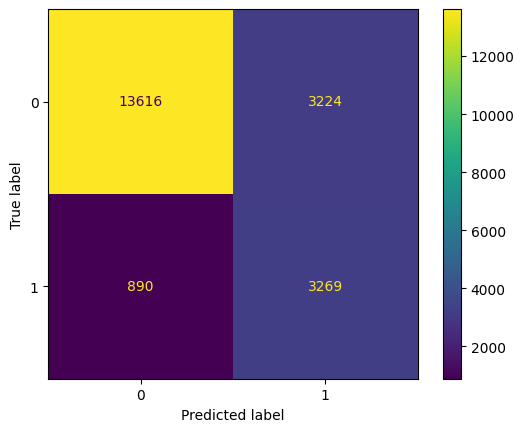

In [94]:
#forcing model to balance weight accordingly
LR_weightAdj = LogisticRegression(class_weight='balanced')
LR_weightAdj.fit(x_train,y_train)
y_pred = LR_weightAdj.predict(x_val)
print("Score : ",LR_weightAdj.score(x_val,y_val))
print("Recall : ",recall_score(y_val,y_pred))
print("Precision : ",precision_score(y_val,y_pred))
print("F1 Score :",f1_score(y_val,y_pred))
cm = confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay(cm).plot()

In [97]:
#Hyper parameter tuning for regularization C, Making sure model is not overfitted
train_f1_score = []
val_f1_score = []

for la in np.arange(0.01,1000,15):
  model = LogisticRegression(class_weight='balanced',C=1/la)
  model.fit(x_train,y_train)
  train_f1_score.append(f1_score(y_train,model.predict(x_train)))
  val_f1_score.append(f1_score(y_val,model.predict(x_val)))



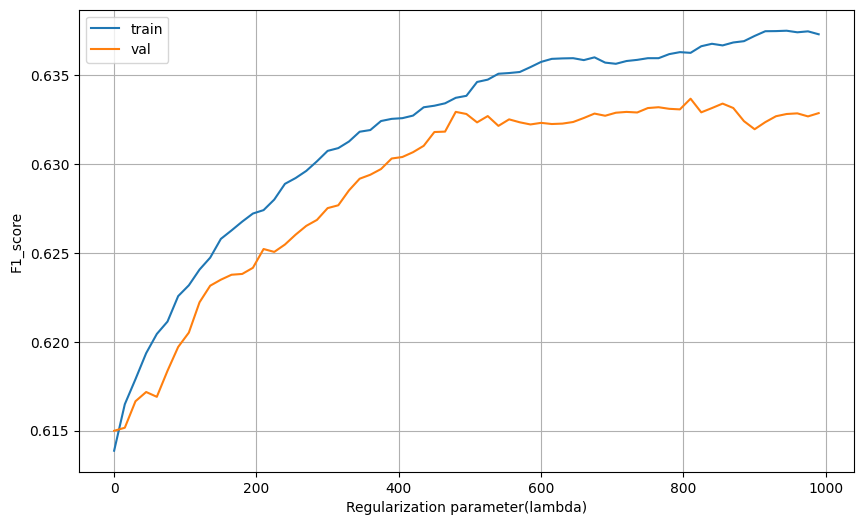

In [99]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0.01,1000,15),train_f1_score, label='train')
plt.plot(np.arange(0.01,1000,15),val_f1_score, label='val')
plt.legend()
plt.xlabel("Regularization parameter(lambda)")
plt.ylabel("F1_score")
plt.grid()
plt.show()



In [101]:
#Lambda for which we are getting maximum F1 score
np.arange(0.01,1000,15)[np.argmax(val_f1_score)]


np.float64(810.01)

In [102]:
#Final model with tuned hyper parameter
final_model = LogisticRegression(class_weight='balanced',C=1/810.01)
final_model.fit(x_train,y_train)

LogisticRegression(C=0.0012345526598437056, class_weight='balanced')

Score :  0.8378018000857184
Recall :  0.7083433517672517
Precision :  0.5732632807939287
F1 Score : 0.6336846633684663


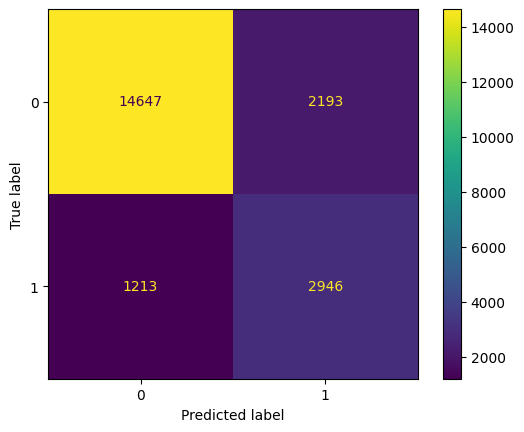

In [118]:
#All different scored for model prediction : in our case we will be focusing more on F1 score as we need to minimize both FP and FN
y_pred_val = final_model.predict(x_val)
print("Score : ",final_model.score(x_val,y_val))
print("Recall : ",recall_score(y_val,y_pred_val))
print("Precision : ",precision_score(y_val,y_pred_val))
print("F1 Score :",f1_score(y_val,y_pred_val))
cm = confusion_matrix(y_val,y_pred_val)
ConfusionMatrixDisplay(cm).plot()

In [104]:
print("F1 score train: ",f1_score(y_train,final_model.predict(x_train)))
print("F1 score val: ",f1_score(y_val,final_model.predict(x_val)))

F1 score train:  0.6362650863626509
F1 score val:  0.6336846633684663


In [123]:
# Lets see the precision_recall curve
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
precisions, recalls, thresholds = precision_recall_curve(y_val,final_model.predict_proba(x_val)[:,1])

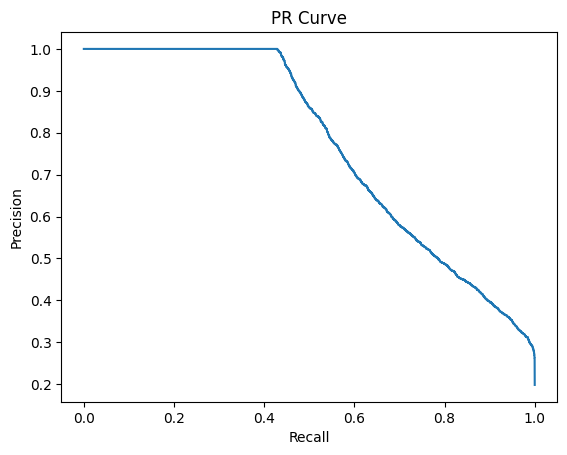

In [124]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.show()

In [125]:
probabilities = final_model.predict_proba(x_val)[:,1]
fpr, tpr, thres = roc_curve(y_val,probabilities)

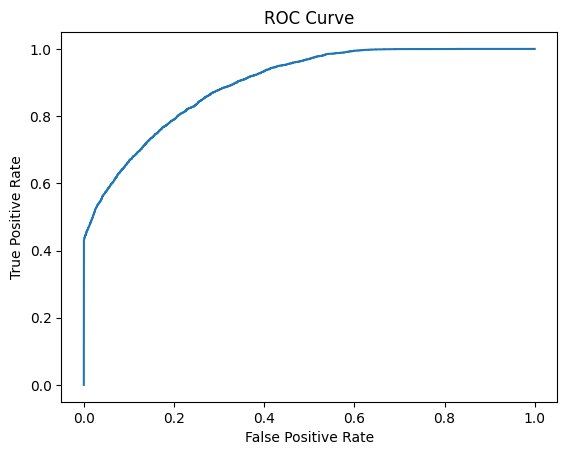

In [126]:
#ROC curve to see relation between FPR and TPR
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [109]:
roc_auc_score(y_test,probabilities)

np.float64(0.49882238103993787)

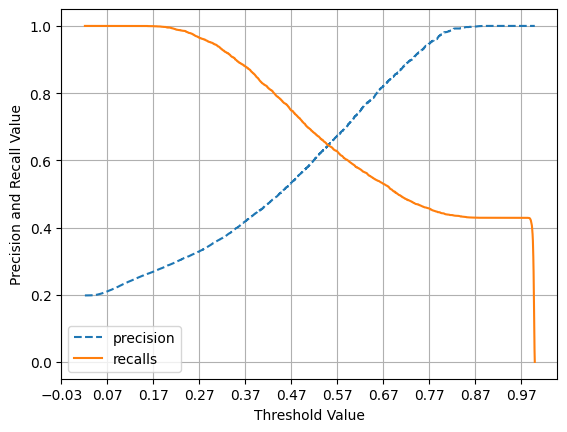

In [110]:
#plotting recall vs precision curve to get best threshold probability
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

probabilities = final_model.predict_proba(x_val)[:,1]
precision_recall_curve_plot(y_val, probabilities)



In [117]:
y_test_pred = final_model.predict_proba(x_test)[:,1]
y_test_pred = np.where(y_test_pred>0.55,1,0)

print("Final F1_score : ",f1_score(y_test,y_test_pred))

Final F1_score :  0.6472142170989433


RangeIndex(start=0, stop=14, step=1)

# Closing Statement & Recommendations
In this project, we developed a robust logistic regression model capable of predicting loan default risk using a diverse set of application and credit-history features. Rigorous data exploration, feature engineering, and multicollinearity management were applied to maximize predictive accuracy and business value. The model demonstrates solid recall and precision, which are essential for minimizing financial loss due to defaults.

**Key Recommendations for Using This Model:**

Integrate the model in the loan approval workflow:
Deploy the model as an automatic screening tool at the application stage. Prioritize manual review or stricter criteria for applicants flagged as "high risk" by the model.

**Balance revenue and risk:**
Focus especially on reducing false negatives (i.e., applicants predicted as low risk but who would default). Given the cost of default, it may be prudent to err on the side of caution, potentially sacrificing some approvals for a stronger risk profile.

**Monitor and retrain regularly:**
The profile of defaulting borrowers may change over time. Periodically retrain and recalibrate the model using latest data to maintain optimal performance.

**Use model explanations and features in decision-making:**
The features with the strongest influence on default risk (e.g., interest rate, term, credit grade, employment history) can guide further customer verification and credit policy refinement.

**Communicate risk transparently:**
Consider providing risk scores and reasons to users or internal stakeholders to encourage fair, explainable, and regulatory-compliant lending practices.